In [1]:
#make sure the notebook only uses the rtx 3090, and memory growth is allowed
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import random
import numpy as np
import tensorflow as tf
import re
from collections import Counter
from tensorflow.python.client import device_lib
from os import listdir

In [3]:
#just to make sure, check the gpu tf uses
print("Tensorflow device: " + re.search('name: (.+?),', str(device_lib.list_local_devices()[1])).group(1))

Tensorflow device: NVIDIA GeForce RTX 3070


In [4]:
#fix random seeds on the cpu and the gpu for reproducability
SEED = 6753
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
#The code works with tensorflow 1 (1.15), but I have tensorflow 2 that I will use as tf1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions, InceptionV3 
from sklearn.model_selection import train_test_split
from IPython.display import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
import pandas as pd
import glob
import sklearn.preprocessing as skp

In [7]:
csv_file = pd.read_csv('LabelsVA_Feb.csv')
specs_dir = glob.glob('Mono/MelSpecs/*.jpeg')
test_dir = glob.glob('Mono/TestSpec/*.jpeg')

In [16]:
for file in test_dir:
     spect = load_img(file, target_size=(75, 75))

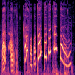

In [17]:
spect

In [18]:
def shuffle_split_files_labels(splitby, csv_file, specs_dir): #new function for splitting-checked-working
        
    labels = csv_file
    filenames_melspecs = []
    spects = list()
    
    for file in specs_dir:
        spect = load_img(file, target_size=(75, 75))
        spect = preprocess_input(img_to_array(spect))
        #spect = img_to_array(spect)
        #experimenting with sizes
        #spect = tf.image.resize_images(spects, (160, 120))
        #need to be a np array for the split
        spects.append(spect)

    for filename in specs_dir:
        filenames_melspecs.append(os.path.splitext(os.path.basename(filename))[0])

    df = pd.DataFrame(filenames_melspecs, columns = ['Filename'])
    df['V'] = df['Filename'].map(labels.set_index('Filename')['V'])
    df['A'] = df['Filename'].map(labels.set_index('Filename')['A'])
    Labels = df
    Vlabels = Labels.pop('V')
    Alabels = Labels.pop('A')
    scaler = skp.MinMaxScaler(feature_range=(0, 1))
    LabelsV = scaler.fit_transform(np.array(Vlabels).reshape(-1, 1))
    LabelsA = scaler.fit_transform(np.array(Alabels).reshape(-1, 1))

    def shuffle_in_unison(a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)

    LabelsAll = np.hstack((LabelsV,LabelsA))
    shuffle_in_unison(spects,LabelsAll)

    split = int(len(spects)*splitby)
    train_data = spects[:split]
    train_labels = LabelsAll[:split] 
    test_data = spects[split:]
    test_labels = LabelsAll[split:]
        
    return train_data, test_data, train_labels, test_labels

In [19]:
train_data, test_data, train_labels, test_labels = shuffle_split_files_labels(0.7, csv_file, specs_dir)

In [20]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [21]:
train_labels_V,train_labels_A = np.hsplit(train_labels,2)
test_labels_V,test_labels_A = np.hsplit(test_labels,2)

In [22]:
test_labels_V.shape

(168, 1)

In [23]:
train_data = np.array(train_data)
test_data = np.array(test_data)

In [24]:
train_data.shape

(392, 75, 75, 3)

In [ ]:
#experimenting with sizes
#spects = tf.image.resize_images(spects, (160, 120))
#need to be a np array for the split
#sess = tf.Session()
#with sess.as_default():
#    spects = spects.eval()

In [ ]:
#train_data = tf.image.resize_images(train_data, (160, 120))
#test_data = tf.image.resize_images(test_data, (160, 120))
#sess = tf.Session()
#with sess.as_default():
#    train_data = train_data.eval()
#    test_data = test_data.eval

In [ ]:
#print(spects.shape, labels.shape)

In [ ]:
#Counter(labels)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(spects, labels, test_size=0.25, stratify=labels)
#y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes=3), tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
#print(Counter(y_test), Counter(y_train))

In [25]:
model = InceptionV3(include_top=False, input_shape=(75, 75, 3))
#model = InceptionV3(include_top=False, input_shape=(640, 480, 3))
#retrain completely, or pure fine-tuning with transfer learning? (transfer learning overfits even faster)
for layer in model.layers:
    layer.trainable = False
flat1 = Flatten()(model.layers[-1].output)
drop1 = Dropout(0.3)(flat1)
class1 = Dense(512, activation='relu')(drop1)  
output = Dense(1)(class1)
model = Model(inputs=model.inputs, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
model.compile(loss='mean_absolute_error', optimizer='Adam')

In [27]:
model.fit(train_data,
          train_labels_V,
          validation_data=(test_data, test_labels_V),
          epochs=200,
          batch_size=16, shuffle=True)

Train on 392 samples, validate on 168 samples
Epoch 1/200
392/392 [==============================] - ETA: 0s - loss: 0.8589

C:\Users\ahmed\anaconda3\envs\TF 26 for ModelMaker\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


392/392 [==============================] - 6s 16ms/sample - loss: 0.8589 - val_loss: 0.6017
Epoch 2/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.2092 - val_loss: 0.5738
Epoch 3/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1912 - val_loss: 0.5679
Epoch 4/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1895 - val_loss: 0.5293
Epoch 5/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1768 - val_loss: 0.6426
Epoch 6/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1813 - val_loss: 0.6725
Epoch 7/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1648 - val_loss: 0.6890
Epoch 8/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1813 - val_loss: 0.4668
Epoch 9/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1769 - val_loss: 0.4357
Epoch 10/200
392/392 [==============================] - 1s 2ms/sample - loss: 0.1783

In [ ]:
predictionsV = []
for i in range(len(test_data)):
    predictionsV.append(model.predict(test_data[i:i+1]))


In [ ]:
predictionsV

In [ ]:
predictionsV = np.squeeze(predictionsV,axis=1)

In [ ]:
predictionsV

In [ ]:
test_labels_V

In [ ]:
predictionsV

In [ ]:
errorV = np.absolute(test_labels_V - predictionsV)

In [ ]:
errorV

In [ ]:
error_avg_V = np.average(errorV)

In [ ]:
error_avg_V